# 🎨 Image Colorization with GAN (Only 20 colors)

This notebook demonstrates the use of a Generative Adversarial Network (GAN) to colorize grayscale images. The model used here, referred to as the "20 colors model", has been trained to restore only 20 colors versions of black and white images, producing natural and visually appealing results.

## 🔍 What You’ll Find in This Notebook:
- 🖼️ Input Transformation: Uploaded images are converted to grayscale and preprocessed for the model.
- 🎨 Colorization Process: The model infers the colored version of the input image.
- 📊 Visualization: Side-by-side display of the grayscale and generated colored images.

## 🧠 About the Model
This GAN model uses a U-Net-based generator architecture to predict color information from luminance. It's trained on a diverse dataset of images to capture a wide range of color combinations, making it capable of generating vivid and varied color outputs.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from PIL import Image


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
grey_path = "/content/drive/MyDrive/DEEp/Proyecto 2/Data/Data copy/grey_20colors"
color_path = "/content/drive/MyDrive/DEEp/Proyecto 2/Data/Data copy/20colors"

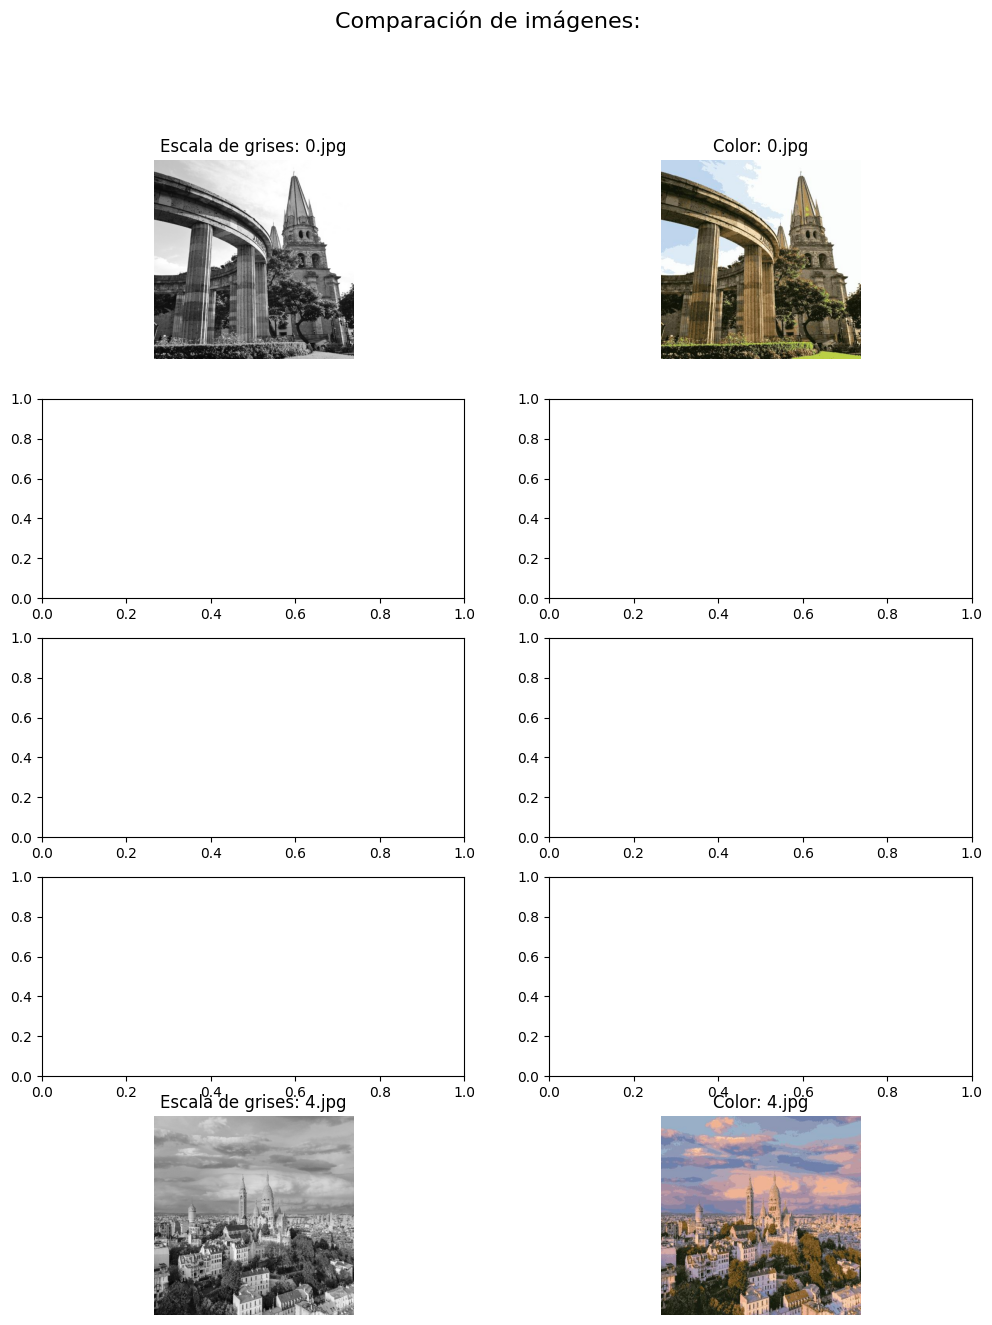

In [4]:
num_images = 5

fig, axes = plt.subplots(num_images, 2, figsize=(12, 15))
fig.suptitle('Comparación de imágenes: ', fontsize=16)

for i in range(num_images):
    grey_img_path = os.path.join(grey_path, f"{i}.jpg")
    color_img_path = os.path.join(color_path, f"{i}.jpg")

    if os.path.exists(grey_img_path) and os.path.exists(color_img_path):
        #Load Images
        grey_img = Image.open(grey_img_path)
        color_img = Image.open(color_img_path)

        axes[i, 0].imshow(np.array(grey_img), cmap='gray')
        axes[i, 0].set_title(f'Escala de grises: {i}.jpg')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(np.array(color_img))
        axes[i, 1].set_title(f'Color: {i}.jpg')
        axes[i, 1].axis('off')



In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb


In [ ]:
wandb.login(relogin=True, force=True)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: perezromomariapaula (perezromomariapaula-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
class CityDataset(Dataset):
    def __init__(self, grey_dir, color_dir, transform=None):
        self.grey_dir = grey_dir
        self.color_dir = color_dir
        self.filenames = sorted(os.listdir(grey_dir))
        self.transform = transform

    def __len__(self):
        return len(self.filenames) 

    def __getitem__(self, idx):
        grey_path = os.path.join(self.grey_dir, self.filenames[idx])
        color_path = os.path.join(self.color_dir, self.filenames[idx])

        grey_image = Image.open(grey_path).convert("L")  # 1 channel, greyscale
        color_image = Image.open(color_path).convert("RGB") # color

        if self.transform:
            grey_image = self.transform(grey_image)
            color_image = self.transform(color_image)

        return grey_image, color_image


In [8]:
transform = transforms.Compose([
    transforms.Resize((256, 256)), #all images to 265x256
    transforms.ToTensor()
])

grey_path = "/content/drive/MyDrive/DEEp/Proyecto 2/Data/Data copy/grey_20colors"
raw_path = "/content/drive/MyDrive/DEEp/Proyecto 2/Data/Data copy/20colors"

dataset = CityDataset(grey_path, raw_path, transform) 
dataloader = DataLoader(dataset, batch_size=4, shuffle=True) 


In [9]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(# input (1 x 256 x 256)
            nn.Conv2d(1, 64, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(True),
        ) #bottleneck  32x32
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()  # output  (3 x 256 x 256)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [10]:
class PatchDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1), nn.LeakyReLU(0.2), # 1 greyscale + 3 rgb
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, 4, 1, 1), nn.Sigmoid()
        )

    def forward(self, grey, color):
        x = torch.cat([grey, color], dim=1)  # channel 1 + channel 3 → 4 channels
        return self.net(x)
    


In [11]:
def train(generator, discriminator, dataloader, device, epochs=20):
    criterion_GAN = nn.BCELoss() #binary cross entropy
    criterion_L1 = nn.L1Loss() #l1 loss

    opt_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999)) #generator optimization
    opt_D = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999)) #discriminator optimization
    for epoch in range(epochs): #train
        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for grey, real_color in loop:
            grey, real_color = grey.to(device), real_color.to(device)

            # ---------Train Discrominator ---------
            fake_color = generator(grey) #generate colored image
            real_pred = discriminator(grey, real_color)  #Discriminator says if its real or colores
            fake_pred = discriminator(grey, fake_color.detach()) 

            real_loss = criterion_GAN(real_pred, torch.ones_like(real_pred)) # Real -> 1 
            fake_loss = criterion_GAN(fake_pred, torch.zeros_like(fake_pred)) # Colored -> 0 
            loss_D = (real_loss + fake_loss) / 2 # average of both predictions

            opt_D.zero_grad()
            loss_D.backward()
            opt_D.step()

            # --------- Train generator ---------
            fake_pred = discriminator(grey, fake_color) # generated images goes through discriminator
            loss_G_GAN = criterion_GAN(fake_pred, torch.ones_like(fake_pred)) 


            #L1 Loss: difference between generated and real
            loss_G_L1 = criterion_L1(fake_color, real_color) * 100  # L1 loss 

            # Total loss of generator:combines GAN loss and l1 loss
            loss_G = loss_G_GAN + loss_G_L1

            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()

            loop.set_postfix({"D_loss": loss_D.item(), "G_loss": loss_G.item()})





In [12]:

def show_sample(generator, dataset, device):
    generator.eval()
    grey, real_color = dataset[0]
    grey = grey.unsqueeze(0).to(device)
    with torch.no_grad():
        fake_color = generator(grey)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(grey.squeeze().cpu(), cmap="gray")
    axs[0].set_title("Input (Grey)")
    axs[1].imshow(real_color.permute(1, 2, 0))
    axs[1].set_title("Ground Truth")
    axs[2].imshow(fake_color.squeeze().permute(1, 2, 0).cpu().numpy())
    axs[2].set_title("Generated")
    plt.show()


In [ ]:
wandb.init(project="coloring", name="#2_20color")


Epoch 200/200: 100%|██████████| 136/136 [00:08<00:00, 16.34it/s, D_loss=0.271, G_loss=13.8]


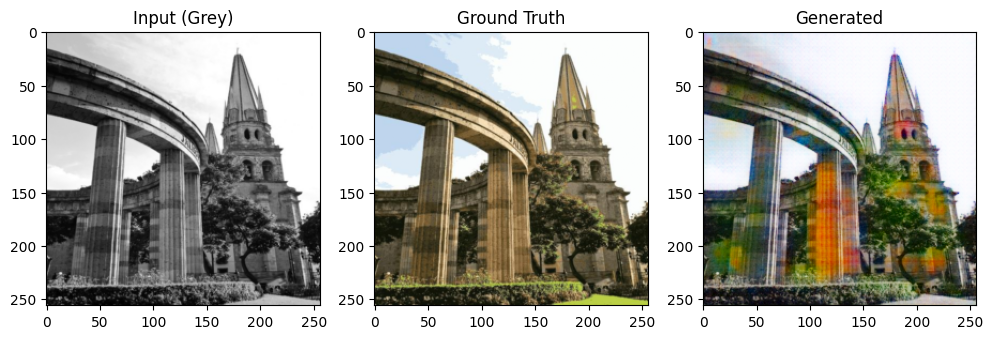

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gen = UNetGenerator().to(device)
disc = PatchDiscriminator().to(device)

train(gen, disc, dataloader, device, epochs=200)
show_sample(gen, dataset, device)


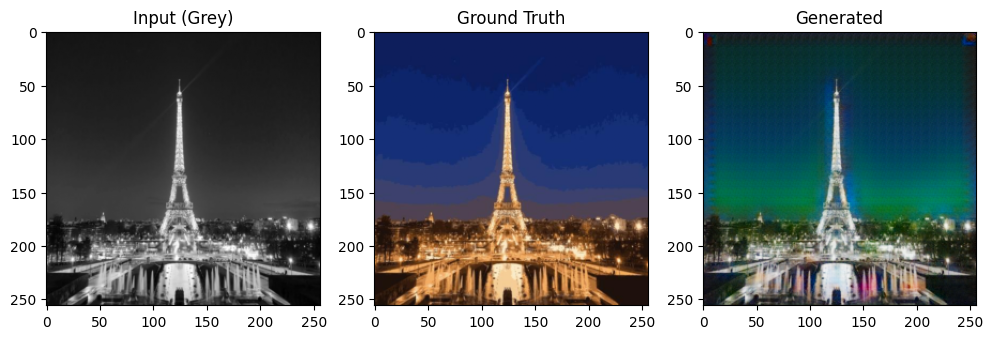

In [14]:

def show_sample(generator, dataset, device):
    generator.eval()
    grey, real_color = dataset[9]
    grey = grey.unsqueeze(0).to(device)
    with torch.no_grad():
        fake_color = generator(grey)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(grey.squeeze().cpu(), cmap="gray")
    axs[0].set_title("Input (Grey)")
    axs[1].imshow(real_color.permute(1, 2, 0))
    axs[1].set_title("Ground Truth")
    axs[2].imshow(fake_color.squeeze().permute(1, 2, 0).cpu().numpy())
    axs[2].set_title("Generated")
    plt.show()

show_sample(gen, dataset, device)


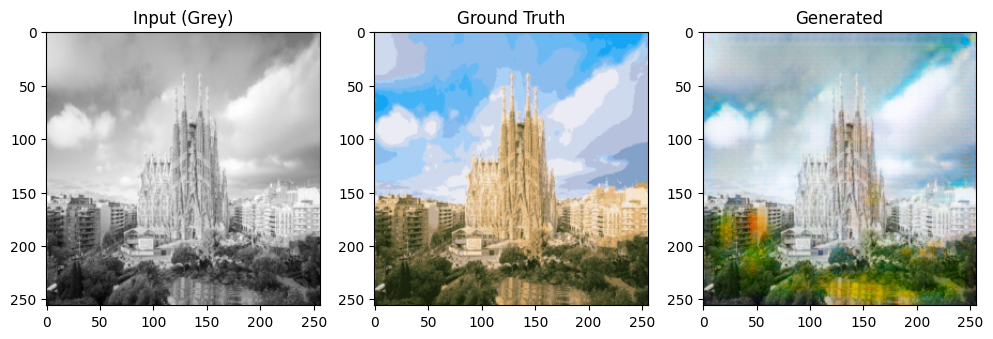

In [15]:

def show_sample(generator, dataset, device):
    generator.eval()
    grey, real_color = dataset[300]
    grey = grey.unsqueeze(0).to(device)
    with torch.no_grad():
        fake_color = generator(grey)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(grey.squeeze().cpu(), cmap="gray")
    axs[0].set_title("Input (Grey)")
    axs[1].imshow(real_color.permute(1, 2, 0))
    axs[1].set_title("Ground Truth")
    axs[2].imshow(fake_color.squeeze().permute(1, 2, 0).cpu().numpy())
    axs[2].set_title("Generated")
    plt.show()

show_sample(gen, dataset, device)


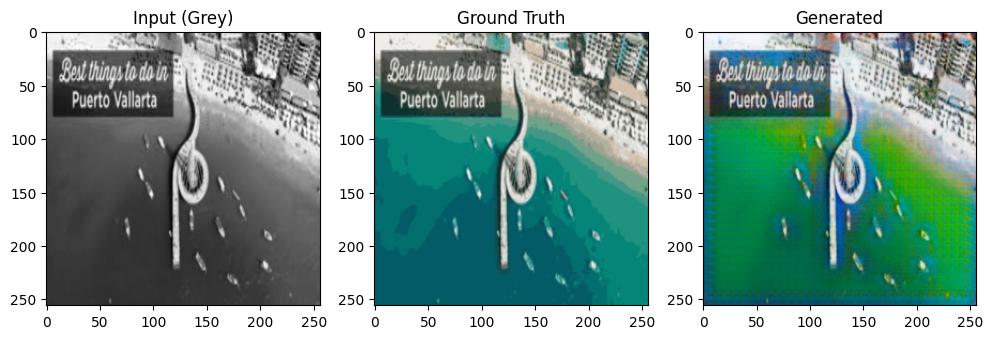

In [16]:

def show_sample(generator, dataset, device):
    generator.eval()
    grey, real_color = dataset[400]
    grey = grey.unsqueeze(0).to(device)
    with torch.no_grad():
        fake_color = generator(grey)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(grey.squeeze().cpu(), cmap="gray")
    axs[0].set_title("Input (Grey)")
    axs[1].imshow(real_color.permute(1, 2, 0))
    axs[1].set_title("Ground Truth")
    axs[2].imshow(fake_color.squeeze().permute(1, 2, 0).cpu().numpy())
    axs[2].set_title("Generated")
    plt.show()

show_sample(gen, dataset, device)


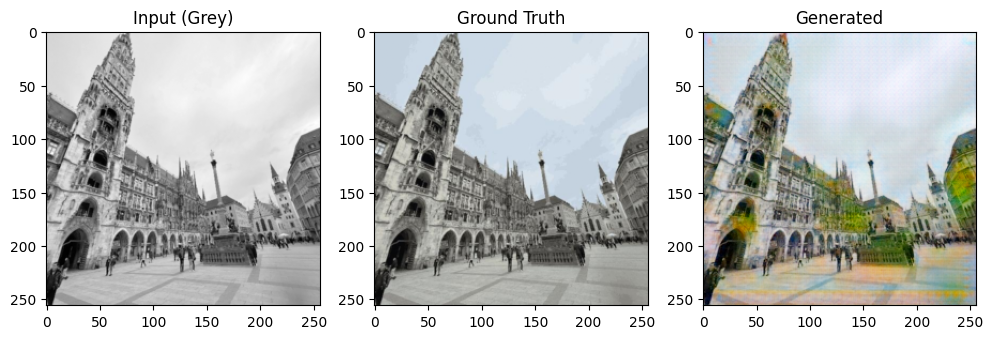

In [17]:

def show_sample(generator, dataset, device):
    generator.eval()
    grey, real_color = dataset[22]
    grey = grey.unsqueeze(0).to(device)
    with torch.no_grad():
        fake_color = generator(grey)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(grey.squeeze().cpu(), cmap="gray")
    axs[0].set_title("Input (Grey)")
    axs[1].imshow(real_color.permute(1, 2, 0))
    axs[1].set_title("Ground Truth")
    axs[2].imshow(fake_color.squeeze().permute(1, 2, 0).cpu().numpy())
    axs[2].set_title("Generated")
    plt.show()

show_sample(gen, dataset, device)


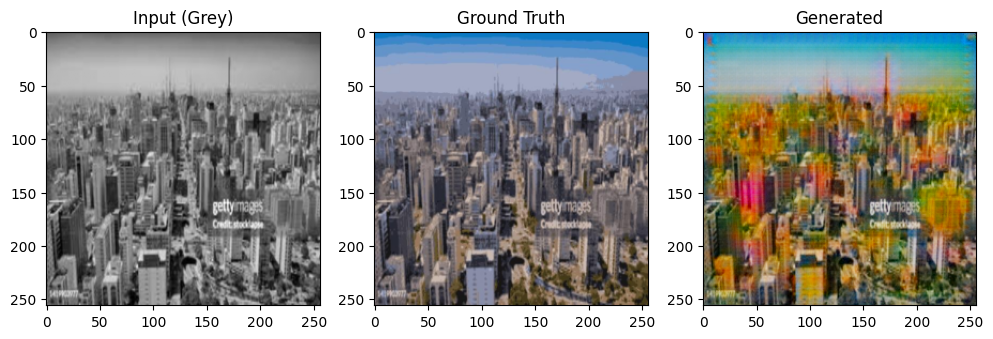

In [18]:

def show_sample(generator, dataset, device):
    generator.eval()
    grey, real_color = dataset[45]
    grey = grey.unsqueeze(0).to(device)
    with torch.no_grad():
        fake_color = generator(grey)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(grey.squeeze().cpu(), cmap="gray")
    axs[0].set_title("Input (Grey)")
    axs[1].imshow(real_color.permute(1, 2, 0))
    axs[1].set_title("Ground Truth")
    axs[2].imshow(fake_color.squeeze().permute(1, 2, 0).cpu().numpy())
    axs[2].set_title("Generated")
    plt.show()

show_sample(gen, dataset, device)


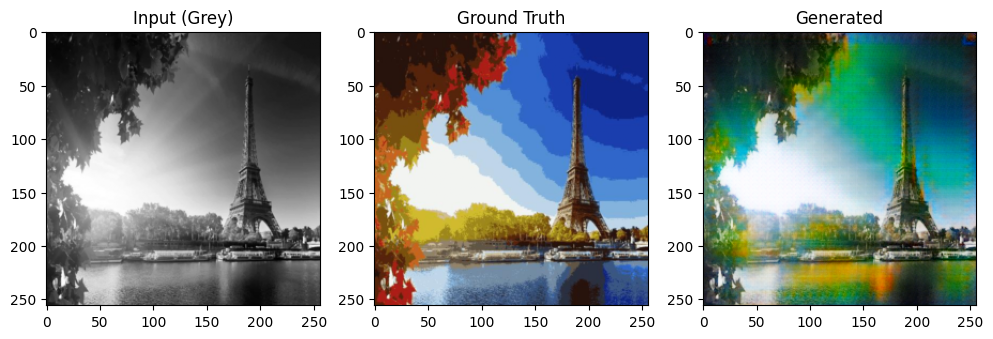

In [19]:

def show_sample(generator, dataset, device):
    generator.eval()
    grey, real_color = dataset[89]
    grey = grey.unsqueeze(0).to(device)
    with torch.no_grad():
        fake_color = generator(grey)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(grey.squeeze().cpu(), cmap="gray")
    axs[0].set_title("Input (Grey)")
    axs[1].imshow(real_color.permute(1, 2, 0))
    axs[1].set_title("Ground Truth")
    axs[2].imshow(fake_color.squeeze().permute(1, 2, 0).cpu().numpy())
    axs[2].set_title("Generated")
    plt.show()

show_sample(gen, dataset, device)


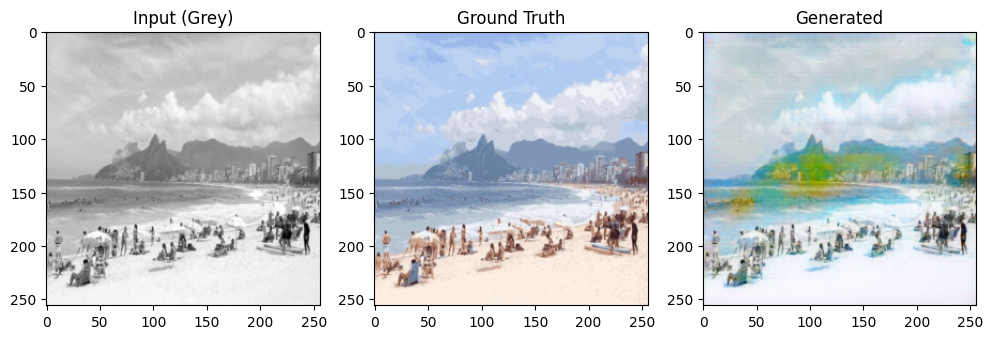

In [20]:

def show_sample(generator, dataset, device):
    generator.eval()
    grey, real_color = dataset[123]
    grey = grey.unsqueeze(0).to(device)
    with torch.no_grad():
        fake_color = generator(grey)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(grey.squeeze().cpu(), cmap="gray")
    axs[0].set_title("Input (Grey)")
    axs[1].imshow(real_color.permute(1, 2, 0))
    axs[1].set_title("Ground Truth")
    axs[2].imshow(fake_color.squeeze().permute(1, 2, 0).cpu().numpy())
    axs[2].set_title("Generated")
    plt.show()

show_sample(gen, dataset, device)


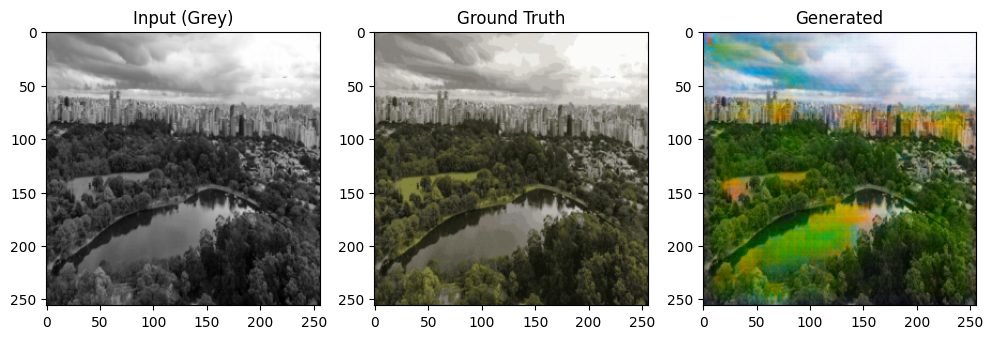

In [21]:

def show_sample(generator, dataset, device):
    generator.eval()
    grey, real_color = dataset[334]
    grey = grey.unsqueeze(0).to(device)
    with torch.no_grad():
        fake_color = generator(grey)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(grey.squeeze().cpu(), cmap="gray")
    axs[0].set_title("Input (Grey)")
    axs[1].imshow(real_color.permute(1, 2, 0))
    axs[1].set_title("Ground Truth")
    axs[2].imshow(fake_color.squeeze().permute(1, 2, 0).cpu().numpy())
    axs[2].set_title("Generated")
    plt.show()

show_sample(gen, dataset, device)


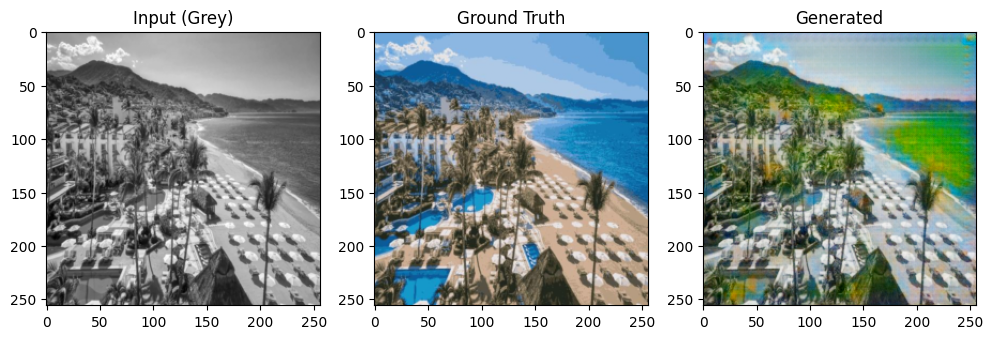

In [22]:

def show_sample(generator, dataset, device):
    generator.eval()
    grey, real_color = dataset[156]
    grey = grey.unsqueeze(0).to(device)
    with torch.no_grad():
        fake_color = generator(grey)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(grey.squeeze().cpu(), cmap="gray")
    axs[0].set_title("Input (Grey)")
    axs[1].imshow(real_color.permute(1, 2, 0))
    axs[1].set_title("Ground Truth")
    axs[2].imshow(fake_color.squeeze().permute(1, 2, 0).cpu().numpy())
    axs[2].set_title("Generated")
    plt.show()

show_sample(gen, dataset, device)


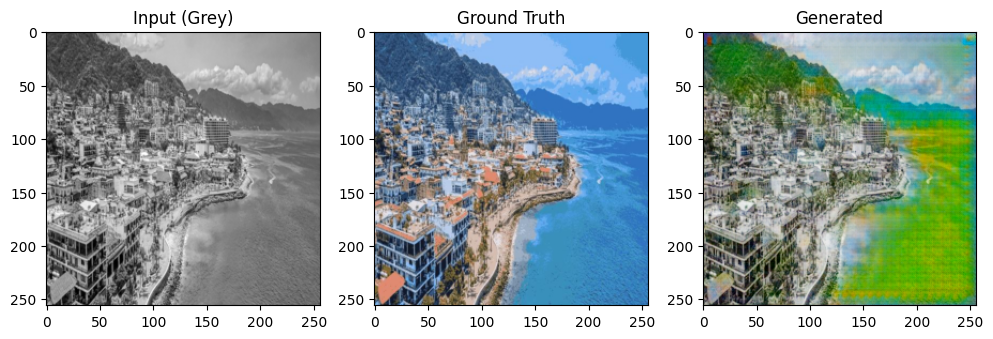

In [23]:

def show_sample(generator, dataset, device):
    generator.eval()
    grey, real_color = dataset[142]
    grey = grey.unsqueeze(0).to(device)
    with torch.no_grad():
        fake_color = generator(grey)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(grey.squeeze().cpu(), cmap="gray")
    axs[0].set_title("Input (Grey)")
    axs[1].imshow(real_color.permute(1, 2, 0))
    axs[1].set_title("Ground Truth")
    axs[2].imshow(fake_color.squeeze().permute(1, 2, 0).cpu().numpy())
    axs[2].set_title("Generated")
    plt.show()

show_sample(gen, dataset, device)


In [24]:
torch.save(gen.state_dict(), "20color_generator.pth")
